In [1]:
from utils_filter import *
from utils_datetime import *
from utils_geography import *
from utils_plotting import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import metpy


In [2]:
# read in data
data_location = 'data'
moderate = False # only consider moderate days
labelled = True # start with already labelled data
outlooks, pph, reports = read_datasets(data_location, moderate, labelled)

reading outlooks
reading pph
reading storm reports


In [3]:
def consolidate_date(outlooks, pph, reports):
    earliest_date = max(min(outlooks['DATE']), min(pph['time']), min(reports['DATE'])) #TODO first two days of outlook dataset don't have day 3 forecast. but probably ok since not mdt
    latest_date = min(max(outlooks['DATE']), max(pph['time']), max(reports['DATE']))
    reports = reports[reports['DATE'] <= latest_date]
    reports = reports[reports['DATE'] >= earliest_date]
    outlooks = outlooks[outlooks['DATE'] <= latest_date]
    outlooks = outlooks[outlooks['DATE'] >= earliest_date]
    all_pph_dates = pph['time']
    pph_dates = all_pph_dates[all_pph_dates <= latest_date]
    pph_dates = pph_dates[pph_dates >= earliest_date]
    pph = pph.sel(time = pph_dates)
    return(outlooks, pph, reports)

(outlooks, pph, reports) = consolidate_date(outlooks, pph, reports)


In [4]:
label_names = ['MAX_CAT', 'RAMP_CATEGORIES', 'SEASON', 'REGION', 'RAMP_UP', 'RAMP_DOWN']

category_dict = {
    'NONE' : -1,
    'TSTM': 0,
    'MRGL': 1,
    'SLGT': 2,
    'ENH': 3,
    'MDT': 4,
    'HIGH': 5
}

ramp_dict = {
    'up': 0,
    'down': 1,
    'both': 2,
    'neither': 3
}

season_dict = {
    'Winter': 0,
    'Spring': 1,
    'Summer': 2,
    'Fall': 3
}

region_dict = {
    'NONE': -1,
    'West': 0,
    'Grea': 1,
    'Midw': 2,
    'Nort': 3,
    'Sout': 4
}

ramp_up_dict = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6
}

ramp_down_dict = {
    '0': 0,
    '-1': 1,
    '-2': 2,
    '-3': 3,
    '-4': 4,
    '-5': 5,
    '-6': 6
}

dicts = [category_dict, ramp_dict, season_dict, region_dict, ramp_up_dict, ramp_down_dict]
written_labels = ['Categorical Risk', 'Ramp', 'Season', 'Region', 'Ramp Up', 'Ramp Down']


In [5]:
def plot_distribution(pph, label_name, label_dict, written_label, titlestring, save_location, show=False):
    labels = pph[label_name]
    label_counts = labels.groupby(labels).count()
    def sort_order(key):
        return label_dict[str(key[0])]
    sorted_labels, sorted_counts = zip(*sorted(zip(list(label_counts[label_name].values), label_counts.values), key = sort_order))
    plt.bar(sorted_labels, sorted_counts)  
    plt.xlabel(written_label)
    plt.title('Number of ' + titlestring + ' Days With Each '  + written_label)
    plt.ylabel("Number of Days")
    plt.savefig(save_location + '/' + written_label + '_distribution.png')
    if show:
        plt.show()
    plt.close()

In [6]:
def plot_distribution_2d(pph, label_1, label_2, label_1_string, label_2_string, dict_1, dict_2, titlestring, save_location, show=False):
# plot 2d heatmap for any 2 labels
    data1 = []
    data2 = []

    for i in range(len(pph[label_1])):
        data1.append(dict_1[str(pph[label_1].values[i])])
        data2.append(dict_2[str(pph[label_2].values[i])])

    max1 = max(dict_1.values())
    min1 = min(dict_1.values())

    max2 = max(dict_2.values())
    min2 = min(dict_2.values())

    bins1 = np.linspace(min1-.5, max1+.5, 2+max1-min1)
    bins2 = np.linspace(min2-.5, max2+.5, 2+max2-min2)

    heatmap = np.histogram2d(data1, data2, bins = (bins1, bins2))
    im = plt.imshow(heatmap[0],  norm=colors.LogNorm())
    plt.colorbar(im)
    for i in range(bins1.size-1): 
        for j in range(bins2.size-1): 
            plt.annotate(str(int(heatmap[0][i][j])), xy=(j, i), 
                        ha='center', va='center', color='black') 

    plt.yticks(range(len(list(dict_1.values()))), labels=list(dict_1.keys()))
    plt.xticks(range(len(list(dict_2.values()))), labels=list(dict_2.keys()))
    plt.ylabel(label_1_string)
    plt.xlabel(label_2_string)
    plt.title("Number of " + titlestring + " Days with each Combination of " + label_1_string + " and " +  label_2_string)
    plt.savefig(save_location + '/' + label_1_string + '_' + label_2_string + '_distribution.png')
    if show:
        plt.show()
    plt.close()

In [7]:
# moderate and up days only:
all_pph_dates = pph['time']
mdt_pph_dates = all_pph_dates[pph['MAX_CAT'].isin(['MDT', 'HIGH'])]
mdt_pph = pph.sel(time = mdt_pph_dates)

# dates since new categorical system 
new_cutoff = '201410230000'
new_pph_dates = all_pph_dates[all_pph_dates >= new_cutoff]
new_pph = pph.sel(time = new_pph_dates)

# Moderate dates in new system
mdt_new_pph_dates = mdt_pph_dates[mdt_pph_dates >= new_cutoff]
mdt_new_pph = pph.sel(time = mdt_new_pph_dates)

In [8]:
def make_plots(pph, label_names, dicts, written_labels, shortstring, titlestring, show=False):
    for i in range(len(written_labels)):
        plot_distribution(pph, label_names[i], dicts[i], written_labels[i], titlestring, 'plots/label_distributions/'+ shortstring+'/1d/', show=show)

    for i in range(len(label_names)):
        for j in range(i):
            plot_distribution_2d(pph, label_names[i], label_names[j], written_labels[i], written_labels[j], dicts[i], dicts[j], titlestring, 'plots/label_distributions/'+ shortstring+'/2d/', show=show)

In [ ]:
make_plots(pph, label_names, dicts, written_labels, 'all', 'All')
make_plots(mdt_pph, label_names, dicts, written_labels, 'mdt', 'Moderate')
make_plots(new_pph, label_names, dicts, written_labels, 'new', 'New')
make_plots(mdt_new_pph, label_names, dicts, written_labels, 'mdt_new', 'Moderate New')


# OLD NON-GENERALIZED PLOTTING OF RAMPS / SCRATCH WORK

In [ ]:
def plot_ramps(pph, title_insert=''):
    # 2d histogram of ramps
    # NOT FOR USE
    ramp_up_bins = [-.5, .5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
    ramp_up_amounts = [0, 1, 2, 3, 4, 5, 6]
    ramp_down_amounts = [-6, -5, -4, -3, -2, -1, 0]
    ramp_down_bins = [-6.5, -5.5, -4.5, -3.5, -2.5, -1.5, -.5, .5]
    heatmap = np.histogram2d(np.array(pph['RAMP_UP'][pph['RAMP_UP']!= 'NONE'], dtype=int), np.array(pph['RAMP_DOWN'][pph['RAMP_UP']!= 'NONE'], dtype=int), bins = (ramp_up_bins, ramp_down_bins))
    im = plt.imshow(heatmap[0],  norm=colors.LogNorm())
    plt.colorbar(im)
    bins = len(ramp_up_bins)
    for i in range(bins-1): 
        for j in range(bins-1): 
            plt.annotate(str(int(heatmap[0][i][j])), xy=(j, i), 
                        ha='center', va='center', color='black') 

    plt.xticks(ramp_up_amounts, labels=ramp_down_amounts)
    plt.yticks(ramp_up_amounts, labels=ramp_up_amounts)
    plt.xlabel("Ramp Down")
    plt.ylabel("Ramp Up")
    plt.title("Number of " + title_insert + "Days with each Ramp Up and Ramp Down Amount")
    plt.show()

In [ ]:
test_outlooks = outlooks[outlooks['RAMP_UP'] == 4]

In [ ]:
def plot_outlooks_day(outlooks_date, output_location, categories, show=False):
    # plots day 1, 2, and 3 outlooks for a day of given categories (hail, wind, tornado, categorical)
    outlooks_date['PRODISS'] = parse_datetime(outlooks_date['PRODISS'])
    for category in categories:
        outlooks_category = outlooks_date[outlooks_date['CATEGORY'] == category]
        for day in [1, 2, 3]:
            outlooks_category_day = outlooks_category[outlooks_category['DAY'] == day]
            latest_issue_time = np.max(outlooks_category_day['PRODISS'])
            outlooks_category_day = outlooks_category_day[outlooks_category_day['PRODISS'] == latest_issue_time]
            if outlooks_category_day.empty == False:
                ax = outlooks_category_day.plot('THRESHOLD', legend = True)
                plt.title('Day ' + str(day) + ' ' + category + ' outlook for ' + str(outlooks_category_day['DATE'].iloc[0]))
                cx.add_basemap(ax, crs=outlooks_category_day.crs)
                plt.savefig(output_location + '/day' + str(day) + '_' + category + '_' + str(outlooks_category_day['DATE'].iloc[0]) + '.png')
                if not show:
                   plt.close()

def plot_pph_day(pph_date, output_location, categories, show = False):
    for category in categories:
        pph_date_category = pph_date[['p_perfect_' + category, 'lat', 'lon']]
        pph_date_category_sig = pph_date[['p_perfect_sig_' + category, 'lat', 'lon']]

        
        # credit: https://atlas.niu.edu/pperfect/BAMS/notebook_sample.html
        fig=plt.figure(figsize=(9,6))
        plt.style.use('dark_background')
        ax = plt.axes(projection = cp.crs.LambertConformal())
        ax.add_feature(cp.feature.LAND,facecolor='grey')
        ax.add_feature(cp.feature.OCEAN, alpha = 0.5)
        ax.add_feature(cp.feature.COASTLINE,linewidth=0.5)
        ax.add_feature(cp.feature.LAKES, alpha = 0.5)
        ax.add_feature(cp.feature.STATES,linewidth=0.5)

        plt.contourf(pph_date_category.lon.values, pph_date_category.lat.values, pph_date_category['p_perfect_' + category].values[:,:],
                    levels=[0,2], colors=['#FFFFFF'],
                    transform=cp.crs.PlateCarree(), alpha=0.)
        try:
            c = plt.contourf(pph_date_category.lon.values, pph_date_category.lat.values, pph_date_category['p_perfect_' + category].values[:,:],
                    levels=[2,5,10,15,30,45,60,100], colors=['#008b00','#8b4726','#ffc800', '#ff0000', '#ff00ff', '#912cee', '#104e8b'],
                    transform=cp.crs.PlateCarree())
            plt.annotate('PPER Max\n'+str(pph_date_category['p_perfect_' + category].values[:,:].max().round(1))+'%', xy=(0.88, 0.3), xycoords="figure fraction",
                        va="center", ha="center", color='white',fontsize=12,
                        bbox=dict(boxstyle="round", fc="k"))
        except:
            plt.annotate("No Reports", xy=(0.5, 0.5), xycoords="figure fraction",
                        va="center", ha="center", color='white',
                        bbox=dict(boxstyle="round", fc="k"))
            
        try:
            plt.contourf(pph_date_category_sig.lon.values, pph_date_category_sig.lat.values, pph_date_category_sig['p_perfect_sig_' + category].values[0,:,:],
                    levels=[10,100], colors='none', hatches=['////'],
                    transform=cp.crs.PlateCarree())
            plt.contour(pph_date_category_sig.lon.values, pph_date_category_sig.lat.values, pph_date_category_sig['p_perfect_sig_' + category].values[0,:,:],
                    levels=[10,100], colors=['k'],
                    transform=cp.crs.PlateCarree())
        except:
            pass

        if category == 'tor':
            cat_title = 'Tornado'
        elif category == 'hail':
            cat_title = 'Hail'
        else:
            cat_title = 'Wind'

        ax.set_extent([-121, -71, 23, 50])
        plt.title('24 Hour Practically Perfect Hindcast for ' + cat_title)
        plt.colorbar(c,orientation="horizontal", pad=0.01, aspect=50,fraction=.1)
        plt.savefig(output_location + '/pph_' + category + '.png')
        if not show:
            plt.close()

def plot_reports(reports, output_location, categories, show = False):
    # plots all storm reports in reports
    for category in categories:
        reports_category = reports[reports['EVENT_TYPE'] == category]
        reports_category = reports_category[reports_category['BEGIN_LAT'] != '']
        reports_category = reports_category[reports_category['BEGIN_LON'] != '']
        reports_category['geometry'] = [Point(xy) for xy in zip(reports_category["BEGIN_LON"], reports_category["BEGIN_LAT"])]
        ax = reports_category.plot(column = 'significant', markersize = 1)
        #ax.legend(title="Significant")
        plt.title('All ' + category + ' Storm Reports')
        cx.add_basemap(ax, crs = {'init':'epsg:4326'})
        plt.savefig(output_location + '/report_' + category + '.png')
        if not show:
            plt.close()

C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


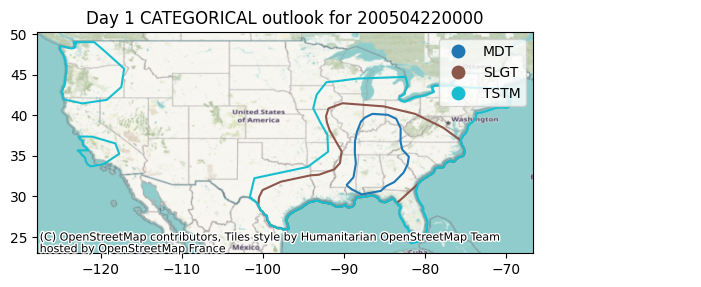

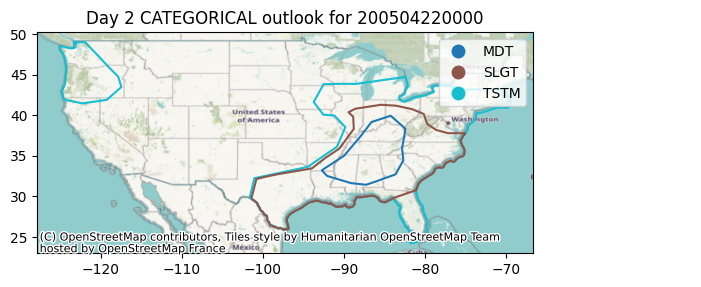

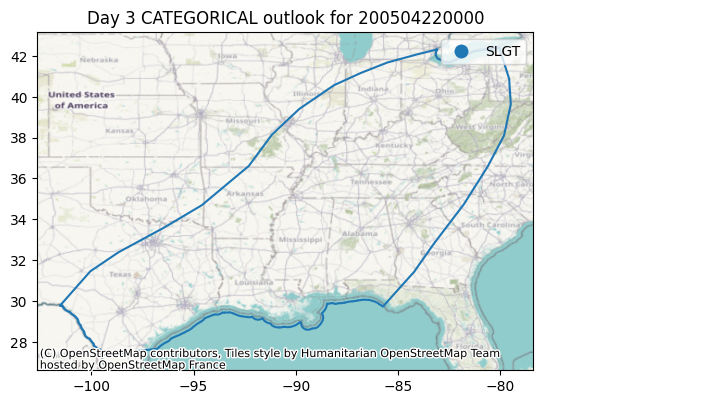

In [9]:
# TODO: make function that plots all 3 outlooks, PPH, and reports for one day to spotcheck
# with utils_plotting functions
def plot_day(datestring, outlooks, pph, reports):
    outlooks_day = outlooks[outlooks['DATE'] == datestring]
    reports_day = reports[reports['DATE'] == datestring]
    pph_day = pph.sel(time=datestring)
    plot_outlooks_day(outlooks_day, 'plots/daily/'+datestring+'/outlooks', ['CATEGORICAL'], show=True)
    plot_pph_day()
    return
plot_day('200504220000', outlooks, pph, reports)